In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import corner
import batman
import emcee
import time
from multiprocessing import Pool
from IPython.display import display, Math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as tck

import pickle

In [2]:
def semi_major_axis_in_stellar_radii(semi_major_axis, R_star):
    """
    Converting the semi-major axis (AU) to (Stellar radii)

    Parameters
    ----------
    semi_major_axis : float
        Semi-major axis of the planet in AU.

    R_star : float
        Stellar radius in R_sun.

    Returns
    -------
    a_stellar_radii : float
        Semi-major axis of the planet in stellar radii.
    """
    #1 AU = 215.032 R_Sun

    a_stellar_radii = semi_major_axis * 215.032 / R_star

    return a_stellar_radii

In [3]:
TIC = 'TIC 66818296' #WASP-17 / TIC 66818296

search_result = lk.search_lightcurve(
    target=TIC,
    mission='TESS', author='SPOC')
print("trying to download")
lc_collection = search_result.download_all()
lc_sector_12 = lc_collection[0].remove_nans()
lc_sector_38 = lc_collection[1].remove_nans()
print("Search done")
print(lc_collection)
lc = lc_collection.stitch(corrector_func=lambda x: x.
                          remove_nans().normalize(unit='unscaled'))
#Sector 12 and sector 38
lc = lc.remove_nans()

trying to download
Search done
LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="TIC 66818296" SECTOR=12 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 66818296" SECTOR=38 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


In [4]:
lc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1628.9527366213874,9.9146342e-01,2.2294226e-03,5.7549695e-03,289074,1734.75869,254.41609,5.6552012e+03,1.2536695e+01,4.5658228e+03,5.9796586e+00,6.3341509e+03,1.4243086e+01,0,———,———,———,———,1734.75869,1.7931858e-03,254.41609,1.7716236e-03,4.0939126e-02,2.0365320e-01
1628.9541255101508,9.9583793e-01,2.2304894e-03,5.7549700e-03,289075,1734.74578,254.42646,5.6748306e+03,1.2542694e+01,4.5680073e+03,5.9771156e+00,6.3620981e+03,1.4249902e+01,0,———,———,———,———,1734.74578,1.7894373e-03,254.42646,1.7657484e-03,2.5400141e-02,2.1769401e-01
1628.955514398915,9.9091458e-01,2.2287809e-03,5.7549705e-03,289076,1734.75697,254.42326,5.6416396e+03,1.2533087e+01,4.5655005e+03,5.9784079e+00,6.3306445e+03,1.4238987e+01,0,———,———,———,———,1734.75697,1.8040523e-03,254.42326,1.7733830e-03,3.9708838e-02,2.1558438e-01
1628.9569032876798,9.9025726e-01,2.2276556e-03,5.7549709e-03,289077,1734.77388,254.40724,5.6449824e+03,1.2526758e+01,4.5653208e+03,5.9806061e+00,6.3264453e+03,1.4231798e+01,0,———,———,———,———,1734.77388,1.8003181e-03,254.40724,1.7727494e-03,5.3074531e-02,1.9718842e-01
1628.9582921764436,9.9405742e-01,2.2288344e-03,5.7549714e-03,289078,1734.75465,254.41574,5.6675269e+03,1.2533387e+01,4.5580649e+03,5.9763598e+00,6.3507231e+03,1.4239328e+01,0,———,———,———,———,1734.75465,1.7944344e-03,254.41574,1.7658967e-03,4.2726278e-02,2.0543911e-01
1628.959681065207,9.9572426e-01,2.2284959e-03,5.7549719e-03,289079,1734.73932,254.42526,5.6712891e+03,1.2531484e+01,4.5560479e+03,5.9750943e+00,6.3613721e+03,1.4237165e+01,0,———,———,———,———,1734.73932,1.7894540e-03,254.42526,1.7633970e-03,2.1659279e-02,2.1886539e-01
1628.961069953971,9.9142510e-01,2.2267138e-03,5.7549723e-03,289080,1734.75758,254.41773,5.6525649e+03,1.2521463e+01,4.5581753e+03,5.9713359e+00,6.3339062e+03,1.4225781e+01,0,———,———,———,———,1734.75758,1.7970275e-03,254.41773,1.7686322e-03,3.9847802e-02,2.0756216e-01
1628.962458842735,9.9342662e-01,2.2281376e-03,5.7549728e-03,289081,1734.75298,254.41704,5.6614937e+03,1.2529469e+01,4.5481836e+03,5.9697313e+00,6.3466934e+03,1.4234877e+01,0,———,———,———,———,1734.75298,1.7935706e-03,254.41704,1.7688903e-03,3.7096344e-02,2.0781381e-01


In [5]:
t = np.array(lc.time.btjd)
flux_data = np.array(lc.flux)
yerrs = np.array(lc.flux_err)

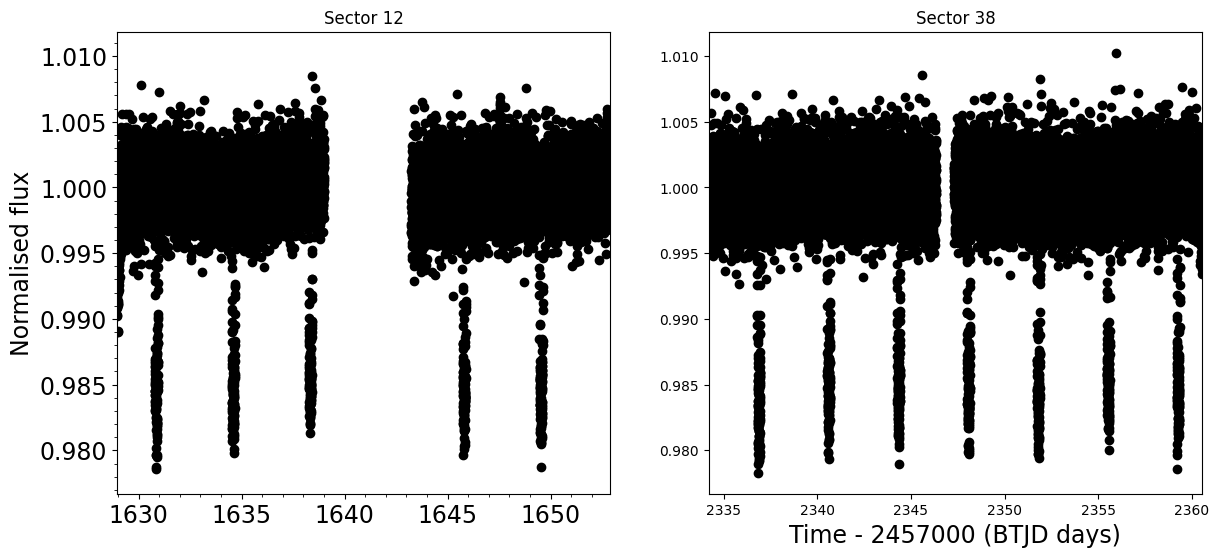

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

#Sector 12
ax1.set_title("Sector 12")
# ax1.scatter(lc.time.btjd, lc.flux, color='Black') #Unbinned
ax1.scatter(t, flux_data, color='Black') #Raw
ax1.set_xlim(min(lc_sector_12.time.btjd), max(lc_sector_12.time.btjd))

#Sector 38
ax2.set_title("Sector 38")
# ax2.scatter(lc.time.btjd, lc.flux, color='Black') #Unbinned
ax2.scatter(t, flux_data, color='Black') #Raw
ax2.set_xlim(min(lc_sector_38.time.btjd), max(lc_sector_38.time.btjd))


ax1.set_ylabel("Normalised flux", size=17)
plt.xlabel("Time - 2457000 (BTJD days)", size=17)

ax1.xaxis.set_tick_params(labelsize=17)
ax1.yaxis.set_tick_params(labelsize=17)

ax1.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax1.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()


In [7]:
filename = "wasp_17b_flat_samples.p"
with open(filename, "rb") as f:
    flat_samples = pickle.load(f)
f.close()

In [8]:
model_T0 = np.percentile(flat_samples[:, 0], 50) #Mid-transit time (Days)
model_Rp = np.percentile(flat_samples[:, 1], 50) #Rp/Rs
model_per = np.percentile(flat_samples[:, 2], 50) #Orbital period (Days)
model_inc = np.percentile(flat_samples[:, 3], 50) #Orbital inclination (Deg)
model_a = np.percentile(flat_samples[:, 4], 50) #a/R

prior_Rs = 1.583 #R_sun Southworth et al. 2012

model_params = batman.TransitParams()
model_params.t0 = model_T0                                          #time of inferior conjunction
model_params.per = model_per                                        #orbital period (days)
model_params.rp = model_Rp                #planet radius (in units of stellar radii)
model_params.a = model_a #semi-major axis (in units of stellar radii))
model_params.inc = model_inc                                     #orbital inclination (in degrees)
model_params.ecc = 0.0                                         #eccentricity
model_params.w = 90.                                          #longitude of periastron (in degrees)
model_params.limb_dark = "quadratic"                          #limb darkening model
model_params.u = [0.21768792859790628, 0.2836292883489928]                          #limb darkening coefficients [u1, u2, u3, u4]

m = batman.TransitModel(model_params, t)                      #initializes model
model_flux = m.light_curve(model_params)

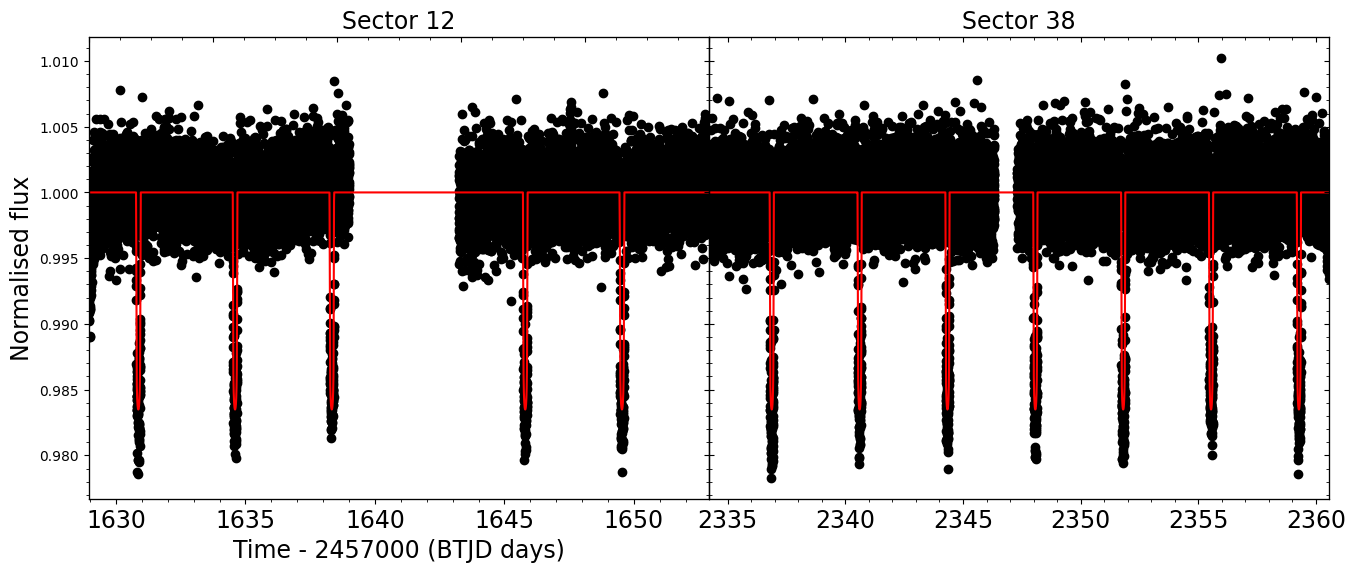

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

#Sector 12
ax1.set_title("Sector 12", size=17)
#Binned data?
ax1.scatter(t, flux_data, color='Black') #Black
ax1.plot(t, model_flux, color='Red')
ax1.set_xlim(min(lc_sector_12.time.btjd), max(lc_sector_12.time.btjd))

# Mirror y
ax1A = ax1.twinx()
ax1A.set_ylim(ax1.get_ylim())
ax1A.get_yaxis().set_ticklabels([])
ax1A.tick_params(which="both", direction="in")#, labelright=True, labelleft=True)

# Mirror x
ax1B = ax1.twiny()
ax1B.set_xlim(ax2.get_xlim())
ax1B.get_xaxis().set_ticklabels([])
ax1B.tick_params(which="both", direction="in")


#Sector 38
ax2.set_title("Sector 38", size=17)
#Binned data?
ax2.scatter(t, flux_data, color='Black') #Black
ax2.plot(t, model_flux, color='Red')
ax2.set_xlim(min(lc_sector_38.time.btjd), max(lc_sector_38.time.btjd))
ax2.set_ylim(ax1.get_ylim())

ax2.get_yaxis().set_ticklabels([])
ax2.tick_params(axis="y",which="both", direction="in")

# Mirror y
ax2A = ax2.twinx()
ax2A.set_ylim(ax2.get_ylim())
ax2A.get_yaxis().set_ticklabels([])
ax2A.tick_params(which="both", direction="in")

# Mirror x
ax2B = ax2.twiny()
ax2B.set_xlim(ax2.get_xlim())
ax2B.get_xaxis().set_ticklabels([])
ax2B.tick_params(which="both", direction="in")



ax1.set_ylabel("Normalised flux", size=17)
ax1.set_xlabel("Time - 2457000 (BTJD days)", size=17)

ax1.xaxis.set_tick_params(labelsize=17)
ax2.xaxis.set_tick_params(labelsize=17)


ax1.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax1B.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax1.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax1A.yaxis.set_minor_locator(tck.AutoMinorLocator())


ax2.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax2B.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax2.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax2A.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.subplots_adjust(wspace=0)
plt.show()
